<a href="https://colab.research.google.com/github/MonkeyWrenchGang/2021-ban7002/blob/main/Week_5_Beer_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beer Recommendation System Using a Simple Collaborative Filter

In this notebook, we'll create a simple beer recommendation system using a form of collaborative filtering. The underlying assumption of our approach is that if a user (let's call them User A) rates beers similarly to another user (User B), User A is likely to rate beers that they haven't tried yet in the same way that User B has.

**Our dataset a sample from beer advocate includes beer reviews with the following columns:**

- reviewer: The username of the person who left the review.
- beer: The name of the beer being reviewed.
- beer_full_name: The name of the brewery: beer name being reviewed.
- rating: The rating given by the reviewer, on a scale of 1 to 5.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
beer = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/2023_BAN6005/main/module_4/data/beer_reviews_sample.csv")
beer.head()

,brewery,beer,reviewer,rating,beer_abv,beer_style,full_beer_name
0,Destiny Brewing Company,Pale Ale,blitheringidiot,4.0,4.5,American Pale Ale (APA),Destiny Brewing Company: Pale Ale
1,Destiny Brewing Company,Pale Ale,NeroFiddled,4.0,4.5,American Pale Ale (APA),Destiny Brewing Company: Pale Ale
2,Destiny Brewing Company,IPA,blitheringidiot,3.5,NaN,American IPA,Destiny Brewing Company: IPA
3,Destiny Brewing Company,IPA,Gavage,3.0,NaN,American IPA,Destiny Brewing Company: IPA
4,Destiny Brewing Company,IPA,NeroFiddled,4.5,NaN,American IPA,Destiny Brewing Company: IPA


# Distribution of Ratings

<Axes: xlabel='rating', ylabel='count'>

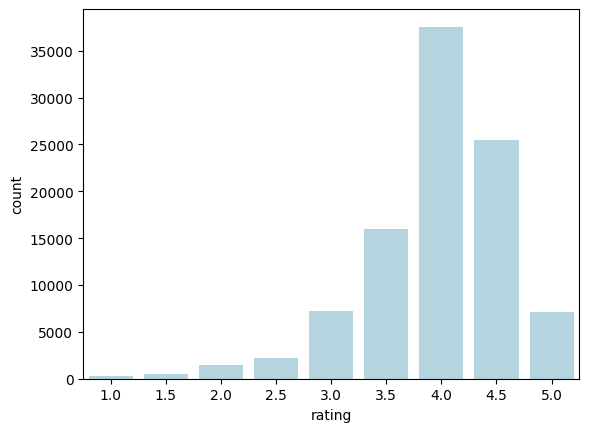

In [ ]:
sns.countplot(beer,x='rating', color='lightblue')

<Axes: xlabel='count', ylabel='reviewer'>

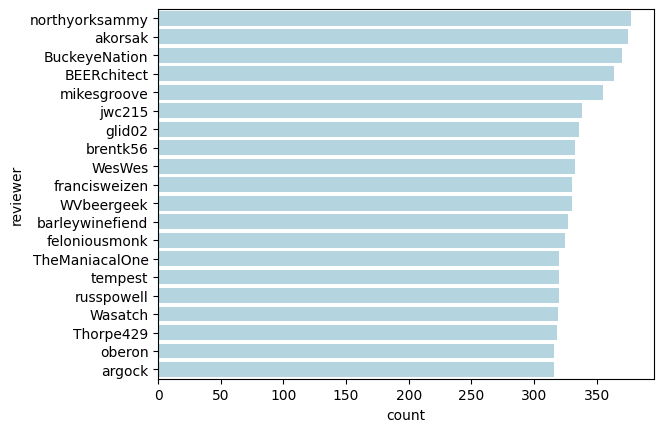

In [ ]:
# top 20 reviewers
res = beer['reviewer'].value_counts().nlargest(20).reset_index()
res.columns = ['reviewer','count']
sns.barplot(res,y='reviewer',x='count', color='lightblue')


Text(0.5, 1.0, 'top 20 most reviewed beers')

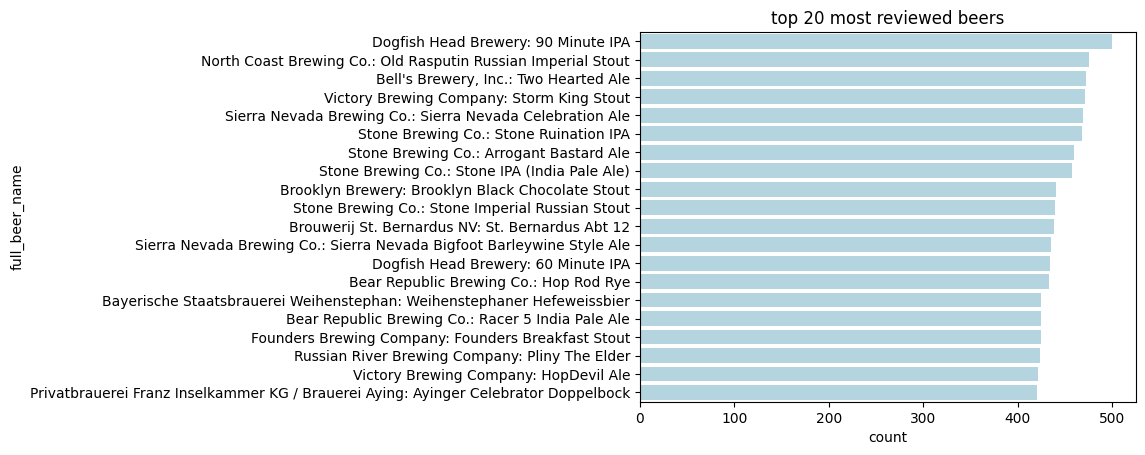

In [ ]:
# top 20 reviewers
res = beer['full_beer_name'].value_counts().nlargest(20).reset_index()
res.columns = ['full_beer_name','count']
sns.barplot(res,y='full_beer_name',x='count', color='lightblue')
plt.title("top 20 most reviewed beers")


# Step 1: Create the User-Item Pivot Table


---

The pivot table will drive the recomendations.

- each row is a reviewer
- each column is a beer
- values is the average rating by the user.

> note we need the nulls! as you'll see later.


In [ ]:
pivot_table = beer.pivot_table(
    index='reviewer',
    columns='full_beer_name',
    values='rating')

pivot_table.head()

full_beer_name,16 Mile Brewing Company: Harvest Ale,1st City Brewery and Grill: Oatmeal Stout,23rd Street Brewery: Porter,4th Street Brewing Co.: Oatmeal Stout,75th Street Brewery: Hefeweizen,Abbaye de Leffe S.A.: Leffe Blonde,Abita Brewing Co.: Turbodog,Airways Brewing Company: Chocolate Stout,Aktien-Brauerei Kaufbeuren AG: Oktoberfest,Alameda Brewhouse: IPA,...,Yards Brewing Co.: India Pale Ale,Yazoo Brewing Company: Hefeweizen,Yazoo Brewing Company: Pale Ale,YellowBelly Brewery & Public House: Pale Ale,Yuengling Brewery : Oktoberfest,Yuengling Brewery : Yuengling Traditional Lager,Z Street Brewing Company: Oktoberfest,Zero Gravity Craft Brewery / American Flatbread: India Pale Ale,Zerodegree Micro-brewery Bar And Restaurant: Pale Ale,Zerodegrees Cardiff: Pale Ale
reviewer,,,,,,,,,,,,,,,,,,,,,
ADR,NaN,NaN,NaN,NaN,NaN,3.0,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKBelgianBeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Absumaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgentMunky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 2: Compute the User Similarity Matrix


`cosine_similarity` measures the similarity between users and items in a  recommendation system.

---

### **What is Cosine Similarity?**

Cosine similarity calculates the cosine of the angle between two non-zero vectors in an n-dimensional space. It measures how similar two vectors are, irrespective of their magnitude. The value ranges from **-1 (completely opposite)** to **1 (exactly the same)**, with **0 indicating orthogonality (no similarity)**.

---

- Purpose: Calculate how similar each user is to every other user based on their rating patterns.
- Normalization:
Missing ratings are replaced with 0 using fillna(0), treating unrated beers as neutral.
- Cosine similarity focuses on the direction of the vectors, which helps mitigate differences in absolute rating scales between users.

---

### **Why Cosine Similarity is Useful in Recommendation Systems**

1. **Focus on Direction, Not Magnitude**:
   - Two users who rate items similarly (e.g., \( [5, 4, 0, 0] \) vs. \( [4, 3, 0, 0] \)) will have high similarity, even if their absolute ratings differ.

2. **Handles Sparse Data Well**:
   - User-item matrices are typically sparse, as not every user rates every item. Cosine similarity naturally deals with such sparsity.

3. **Identifies Similar Users for Collaborative Filtering**:
   - Once similarities are calculated, you can identify "neighbors" for a user (e.g., the top-k most similar users) and use their preferences to recommend items.

---


#### **Steps**:
1. **Prepare Data**:
   - `pivot_table.fillna(0)` ensures no missing values in the user-item matrix.
   
2. **Compute Similarity**:
   - `cosine_similarity` computes the similarity scores between all users.

3. **Store Results**:
   - Convert the matrix into a DataFrame (`similarity_df`) for convenient access. You can now:
     ```python
     # Get top 5 similar users to a given user
     similarity_df[user].nlargest(5)
     ```



In [ ]:
# Calculate similarity between users
similarity_matrix = cosine_similarity(pivot_table.fillna(0))

# Convert to a DataFrame for easier querying and interpretation
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_table.index, columns=pivot_table.index)

similarity_df.head()

reviewer,ADR,ADZA,AKBelgianBeast,Absumaster,AgentMunky,AgentZero,AlCaponeJunior,AleWatcher,AlexJ,AltBock,...,woodychandler,woosterbill,wordemupg,xnicknj,ybnorml,yemenmocha,yesyouam,younger35,yourefragile,zeff80
reviewer,,,,,,,,,,,,,,,,,,,,,
ADR,1.000000,0.436199,0.550372,0.580261,0.571057,0.434412,0.516977,0.388346,0.716834,0.549826,...,0.517424,0.513898,0.554516,0.372478,0.485539,0.586428,0.639718,0.367319,0.360857,0.732091
ADZA,0.436199,1.000000,0.508117,0.418293,0.444660,0.392666,0.455607,0.378443,0.511562,0.482464,...,0.367039,0.454195,0.470970,0.424305,0.271939,0.504103,0.566153,0.412256,0.417012,0.563423
AKBelgianBeast,0.550372,0.508117,1.000000,0.574237,0.565095,0.611067,0.504028,0.505429,0.650692,0.617644,...,0.435066,0.652600,0.492827,0.566968,0.403450,0.583738,0.588246,0.625796,0.582423,0.668391
Absumaster,0.580261,0.418293,0.574237,1.000000,0.584704,0.423629,0.441444,0.404862,0.643439,0.526642,...,0.441738,0.537271,0.484233,0.411856,0.452348,0.510915,0.585708,0.419004,0.394924,0.613874
AgentMunky,0.571057,0.444660,0.565095,0.584704,1.000000,0.448385,0.541681,0.438246,0.643900,0.516355,...,0.436131,0.598502,0.481417,0.511954,0.398232,0.527619,0.576418,0.366476,0.428432,0.652833


In [ ]:
# most similar users to BuckeyeNation
similarity_df["BuckeyeNation"].nlargest(5)

,BuckeyeNation
reviewer,
BuckeyeNation,1.000000
feloniousmonk,0.892766
Wasatch,0.891912
TheManiacalOne,0.891346
BEERchitect,0.887214


## Pull it all together



---



In [ ]:
user = 'BuckeyeNation'

# Fetch the user's reviews
user_reviews = pivot_table.loc[user]

# Identify beers the user hasn't rated yet
not_reviewed = user_reviews[user_reviews.isna()]

# Get global mean ratings for beers
global_recommendations = mean_ratings[not_reviewed.index]

# Find the most similar users
similar_users = similarity_df[user].nlargest(10).index[1:]  # Exclude the user themselves

# Calculate mean ratings from similar users
similar_ratings = pivot_table.loc[similar_users].mean()

# Combine global ratings and collaborative filtering
recommendations = 0.7 * global_recommendations + 0.3 * similar_ratings[not_reviewed.index]

# random top 5 from 20
recommendations.nlargest(20).sample(5)


,0
full_beer_name,
Lancaster Brewing Company: Hefeweizen,4.188889
Pizzeria Uno Chicago Grill & Brewery: Oktoberfest,4.500000
Lunar Brewing: Oktoberfest,4.350000
Harvest Moon Brewery & Cafe: Oatmeal Stout,4.500000
High Desert Brewing Company: Imperial Stout,4.500000


# Make a Function

In [ ]:
def beer_recomender():
  user = 'BuckeyeNation'
  N_largest = 20
  N_recommendations = 5

  # Fetch the user's reviews
  user_reviews = pivot_table.loc[user]

  # Identify beers the user hasn't rated yet
  not_reviewed = user_reviews[user_reviews.isna()]

  # Get global mean ratings for beers
  global_recommendations = mean_ratings[not_reviewed.index]

  # Find the most similar users
  similar_users = similarity_df[user].nlargest(10).index[1:]  # Exclude the user themselves

  # Calculate mean ratings from similar users
  similar_ratings = pivot_table.loc[similar_users].mean()

  # Combine global ratings and collaborative filtering
  recommendations = 0.7 * global_recommendations + 0.3 * similar_ratings[not_reviewed.index]

  # random top 5 from 20
  return recommendations.nlargest(N_largest).sample(N_recommendations).sort_values(ascending=False)

beer_recomender()

,0
full_beer_name,
Climax Brewing Company: India Pale Ale,4.191667
"Mash House Restaurant & Brewery, The: Oktoberfest",4.266667
Richbrau Brewing Company: India Pale Ale,4.116667
Church Brew Works: Imperial Stout,4.500000
Port City Brewing: Porter,4.150000


In [ ]:
# add parameters
def beer_recomender(user, N_largest=20, N_recommendations=5 ):
  # user = 'BuckeyeNation'
  #N_largest = 20
  #N_recommendations = 5

  # Fetch the user's reviews
  user_reviews = pivot_table.loc[user]

  # Identify beers the user hasn't rated yet
  not_reviewed = user_reviews[user_reviews.isna()]

  # Get global mean ratings for beers
  global_recommendations = mean_ratings[not_reviewed.index]

  # Find the most similar users
  similar_users = similarity_df[user].nlargest(10).index[1:]  # Exclude the user themselves

  # Calculate mean ratings from similar users
  similar_ratings = pivot_table.loc[similar_users].mean()

  # Combine global ratings and collaborative filtering
  recommendations = 0.7 * global_recommendations + 0.3 * similar_ratings[not_reviewed.index]

  # random top 5 from 20
  return recommendations.nlargest(N_largest).sample(N_recommendations).sort_values(ascending=False)

beer_recomender(user='BuckeyeNation',
                N_largest = 30,
                N_recommendations= 10)

,0
full_beer_name,
Russian River Brewing Company: Porter,4.613793
Westbrook Brewing Co.: India Pale Ale,4.309091
Climax Brewing Company: India Pale Ale,4.191667
The Defiant Brewing Company: India Pale Ale,4.150000
Port City Brewing: Porter,4.150000
Wedge Brewing Company: Oatmeal Stout,4.116667
John Harvard's Brewery & Ale House: Oktoberfest,4.115000
West Virginia Brewing Company: Oktoberfest,4.033333
Boscos Restaurant & Brewing Co. - Nashville: Oktoberfest,4.000000


# what happens if the user isn't in the data?
---
return the top N beers.

In [ ]:
def beer_recommender(user, N_largest=20, N_recommendations=5):
    # Check if the user exists in the data
    if user not in pivot_table.index:
        print(f"User '{user}' not found. Returning top {N_recommendations} global recommendations.")
        # Return top-rated beers overall
        mean_ratings = pivot_table.mean()
        return mean_ratings.nlargest(N_largest).sample(N_recommendations).sort_values(ascending=False)

    # Fetch the user's reviews
    user_reviews = pivot_table.loc[user]

    # Identify beers the user hasn't rated yet
    not_reviewed = user_reviews[user_reviews.isna()]

    # Get global mean ratings for beers
    global_recommendations = mean_ratings[not_reviewed.index]

    # Find the most similar users
    similar_users = similarity_df[user].nlargest(10).index[1:]  # Exclude the user themselves

    # Calculate mean ratings from similar users
    similar_ratings = pivot_table.loc[similar_users].mean()

    # Combine global ratings and collaborative filtering
    recommendations = 0.7 * global_recommendations + 0.3 * similar_ratings[not_reviewed.index]

    # Randomly select top recommendations from the filtered list
    return recommendations.nlargest(N_largest).sample(N_recommendations).sort_values(ascending=False)

# Example:
beer_recommender(user='MikeAintHere', N_largest=30, N_recommendations=10)


User 'MikeAintHere' not found. Returning top 10 global recommendations.


,0
full_beer_name,
New Belgium Brewing: Pale Ale,5.000000
Morgantown Brewing Company: Oktoberfest,5.000000
Trout River Brewing Company: Imperial Stout,4.750000
Bayerische Staatsbrauerei Weihenstephan: Weihenstephaner Hefeweissbier,4.528659
Bitter Root Brewing: Oktoberfest,4.500000
Bridge Brew Works LLC: Hefeweizen,4.500000
Brodie's: IPA,4.500000
Catamount Brewing Company: Christmas Ale,4.500000
Broadway Brewery & Restaurant: India Pale Ale,4.500000
